# Getting Started
> Fit an LSTM and NHITS model

This notebook provides an example on how to start using the main functionalities of the NeuralForecast library. The `NeuralForecast` class allows users to easily interact with `NeuralForecast.models` PyTorch models. In this example we will forecast AirPassengers data with a classic `LSTM` and the recent `NHITS` models. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).


You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [1]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests as rt, seaborn as sns

from IPython.display import display, Markdown

from io               import BytesIO
from matplotlib       import style
from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from neuralforecast         import NeuralForecast
from neuralforecast.models  import LSTM as nfLSTM, NHITS, RNN, NBEATS
from neuralforecast.auto    import AutoRNN
from neuralforecast.utils   import AirPassengersDF

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from sktime.utils.plotting import plot_series
# from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError

# Ajustes feitos para geração e criação de gráfico
style.use('ggplot')
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

# Mean Absolute Scaled Error -> essa métrica é scaled-free
mase = MeanAbsoluteScaledError()

In [3]:
def sliding_window(data, n_lags=1, n_targets=1, dropnan=True):
	"""
	Rearranja a série temporal como um dataset para aprendizado supervisionado.
	Argumentos:
		data: Sequência de observações. Pode ser list ou NumPy array
		n_lags: Número de lags das observações que serão usadas como input (X).
		n_targets: Número de observações que serão usadas como output (y).
		dropnan: Booleano pra dropar as linhas que ficarem com NaN .
	Retorna:
		Um DataFrame como uma série ajustada para aprendizado supervisionado.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# As lags (t-n, ... t-1)
	for i in range(n_lags, 0, -1):
		cols.append(df.shift(i))
		names += [('X_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Prever uma sequência (t, t+1, ... t+n)
	for i in range(0, n_targets):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('y_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Junta tudo
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# Dropa as linhas com NaN
	if dropnan:
		agg.dropna(inplace=True)

	return agg # IMPORTANTE!!!! O retorno sai com as colunas com nome zuado. Tem que renomear o DataFrame resultante depois.

In [4]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train_data = df.iloc[0:t_size]
  validation_data = df.iloc[t_size:]

  return train_data, validation_data

# Carregando os dados de chuva e vazão da estação telemétrica

In [5]:
def read_telemetrica_chuva_vazao(codigoEstacao, tipoEstacao, chave):
  link = 'https://docs.google.com/spreadsheets/d/' + chave + '/export?format=xlsx'
  r = rt.get(link)
  data = r.content
  df = pd.read_excel(BytesIO(data), sheet_name='telemetrica_56994500', header=0, parse_dates=['data_hora'])

  # Ajustando a coluna correspondente à data para o tipo datetime e convertendo para o formato "Period" de frequência "15T" (a cada 15 minutos)
  # A biblioteca 'sktime' só consegue lidar com o campo 'Data' se estiver neste formato de dado
  # df['data_hora'] = pd.DatetimeIndex(df['data_hora']).to_period('15T')

  # A partir do objeto criado anteriormente, agora eu 'corto' entre TREINO e VALIDAÇÃO
  # Será 75% para TESTE e 25% para VALIDAÇÃO calculados à partir do início da série temporal
  # treino, validacao = temporal_train_test_split(df, train_size=0.75, anchor="start")
  # treino.name, validacao.name = 'Treino', 'Validação'

  # ForecastHorizon, o horizonte de tempo que pretende-se realizar a previsão.
  # Está em questão de meses porque os dados são mensais.
  # A ser utilizado com a biblioteca 'sktime'
  # fh = pd.PeriodIndex(data=validacao.index.values)

  # As colunas importantes para entrada no NeuralForecast/LSTM são mesmo "unique_id", "data_hora" e "vazao".
  # Contudo, se colocar mais coluna que conserva relação com o alvo ("vazao"), isso ajuda a aprimorar mais o resultado do modelo. => DICA IMPORTANTE
  # É com isso em mente que entra a coluna "chuva"
  feature_names = ['chuva', 'vazao']
  target_names = 'vazao'

  # O NeuralForecast/LSTM demanda uma coluna nomeada "unique_id"
  # A coluna serve como identificador ÚNICO da série temporal e pode ser qualquer identificador que separe
  # df['unique_id'] = 1

  # Ajustando as colunas "chuva" e "vazao" para tipo numérico
  df.chuva = pd.to_numeric(df.chuva, errors='coerce')
  df.vazao = pd.to_numeric(df.vazao, errors='coerce')

  # Botando o campo "data_hora" pra índice do DataFrame
  df.set_index('data_hora', inplace=True)

  # Agregando os dados por dia e aplicando a média para "vazao" e somatório para "chuva"
  # Além de reduzir o dataset isso também é importante caso tenha muitos dados faltantes (o que é bastante comum)
  df_media_diaria = df.resample('D').agg({'chuva': np.sum, 'vazao': np.mean})

  dataset =  {
    'task'              : 'Análise de Série Temporal de estação telemétrica',
    'name'              : str('Dados telemétricos - estação %s' % codigoEstacao),
    'reference'         : "...",
    'feature_names'     : feature_names,
    'target_names'      : target_names,
    'n_samples'         : len(df),
    'n_features'        : len(feature_names),
    'full_serie'        : df,
    'agg_by_day'        : df_media_diaria,
    'description'       : "Dados de telemetria disponibilizados pela Agência Nacional de Águas e Saneamento Básico do Brasil - ANA",
    'raw_data'          : link,
    'station_code'      : codigoEstacao,
    'station_type'      : tipoEstacao,
    }

  return (dataset)

In [6]:
# Fazendo a carga dos dados a serem analisados
ds = read_telemetrica_chuva_vazao(codigoEstacao='56994500',
                                  tipoEstacao='Telemétrica',
                                  chave="1hl9KK8cmu3DyRaFHwa3E73KdH5nbDhByW-IySNY5oX0")

# ds

<AxesSubplot:title={'center':'Chuva agregado por dia (somatório)'}, xlabel='data_hora'>

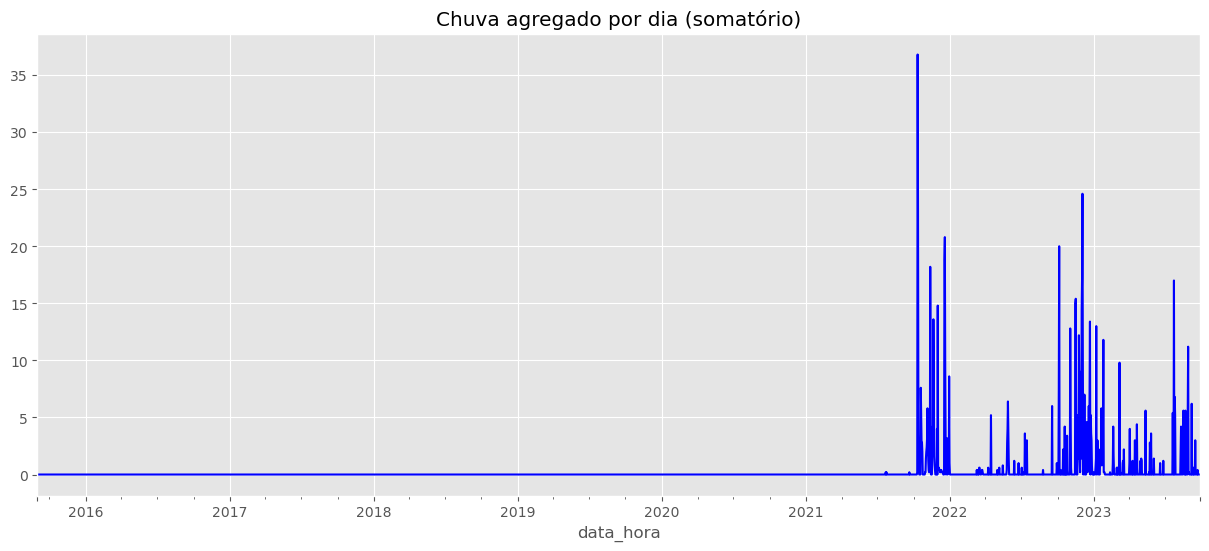

In [7]:
ds['agg_by_day'].chuva.plot(title="Chuva agregado por dia (somatório)", color='b')

<AxesSubplot:title={'center':'Vazão agregada por dia (média)'}, xlabel='data_hora'>

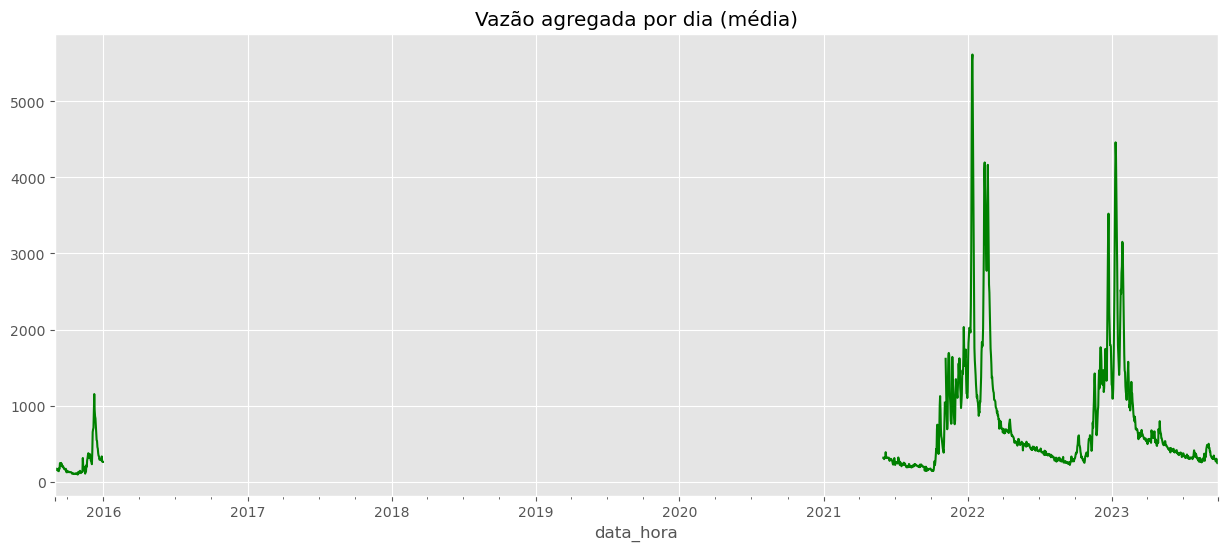

In [8]:
ds['agg_by_day'].vazao.plot(title="Vazão agregada por dia (média)", color='g')

# Pré-processamento dos dados

In [9]:
ds['agg_by_day'].dtypes

chuva    float64
vazao    float64
dtype: object

In [10]:
# Olhando se tem dados faltantes (0 ou NaN) e contando.

ds['agg_by_day'].isna().sum()

chuva       0
vazao    1979
dtype: int64

In [11]:
# Para este dataset, vale à pena mesmo pegar dados a partir de 2021. Tem um salto de anos muito longo, de 2015 para 2021.
# E como para 2015 os dados de chuva estão todos "NaN", seriam excluídos de qualquer forma mesmo.
# Contudo, deixando ".year >= 2021" apenas para compreensão da linha de raciocínio seguida por mim (Welson)

len(ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]), ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021].isna().sum()

(1000,
 chuva      0
 vazao    152
 dtype: int64)

In [12]:
df_media_diaria_2021 = ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]
len(df_media_diaria_2021)

1000

In [13]:
# df_media_diaria.dropna(inplace=True)
# df_media_diaria.shape

df_media_diaria_2021.isna().sum()

chuva      0
vazao    152
dtype: int64

In [14]:
#É possível ver que existem dados de vazão NaN. Estes dados serão cortados
df_media_diaria_2021.dropna(inplace=True)

df_media_diaria_2021.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 848 entries, 2021-06-01 to 2023-09-27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chuva   848 non-null    float64
 1   vazao   848 non-null    float64
dtypes: float64(2)
memory usage: 19.9 KB


# Análise exploratória dos dados

In [15]:
# Especificando a frequência como "diária"

df_media_diaria_2021.asfreq('D')

,chuva,vazao
data_hora,,
2021-06-01,0.0,317.075000
2021-06-02,0.0,317.075000
2021-06-03,0.0,298.230000
2021-06-04,0.0,319.460000
2021-06-05,0.0,312.290000
...,...,...
2023-09-23,0.0,283.482604
2023-09-24,0.0,303.319792
2023-09-25,0.0,289.295000


In [16]:
df_media_diaria_2021

,chuva,vazao
data_hora,,
2021-06-01,0.0,317.075000
2021-06-02,0.0,317.075000
2021-06-03,0.0,298.230000
2021-06-04,0.0,319.460000
2021-06-05,0.0,312.290000
...,...,...
2023-09-23,0.0,283.482604
2023-09-24,0.0,303.319792
2023-09-25,0.0,289.295000


<AxesSubplot:title={'center':'Chuva'}, xlabel='Meses', ylabel='Precipitação (mm)'>

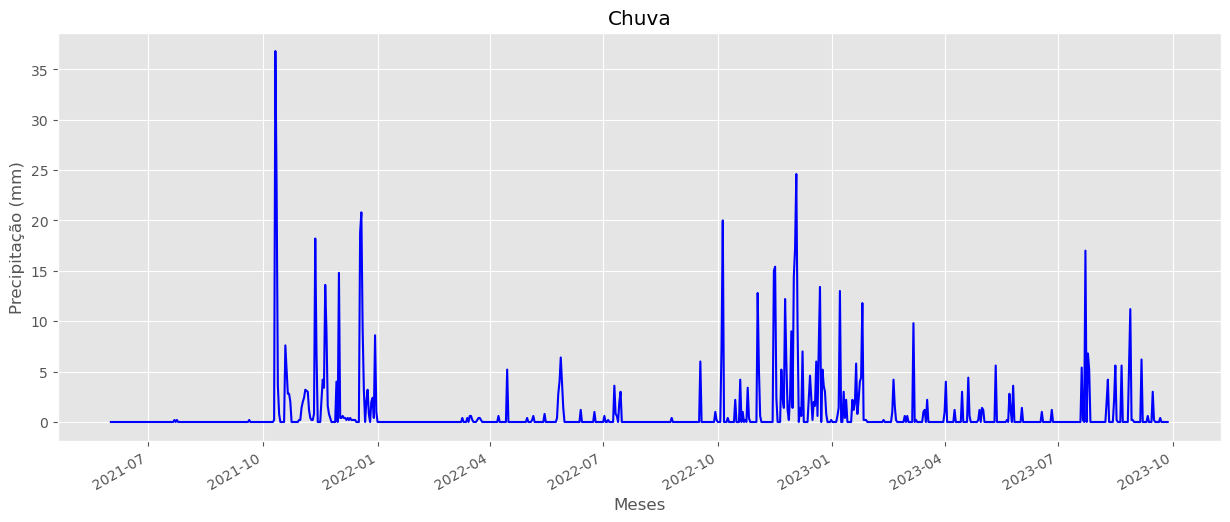

In [17]:
# Plotando a série de chuva
df_media_diaria_2021.chuva.plot(title='Chuva', color='b', xlabel='Meses', ylabel='Precipitação (mm)')

<AxesSubplot:title={'center':'Vazão'}, xlabel='Meses', ylabel='Vazão ($m^3/s$)'>

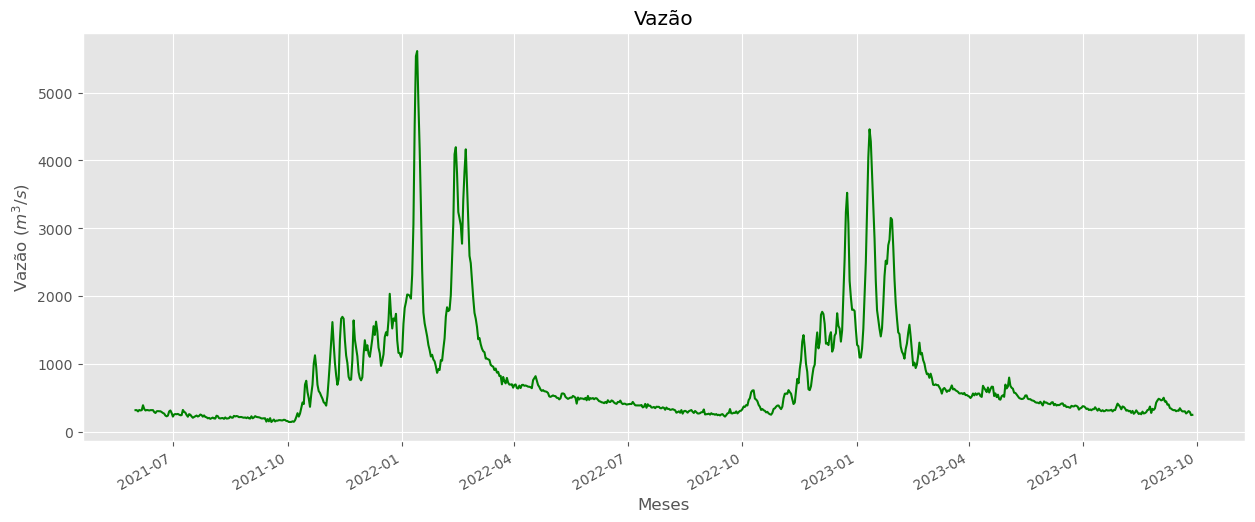

In [18]:
# Plotando a série de vazão
df_media_diaria_2021.vazao.plot(title='Vazão', color='g', xlabel='Meses', ylabel='Vazão ($m^3/s$)')

In [19]:
# Decompondo cada uma das séries analisadas
from statsmodels.tsa.seasonal import seasonal_decompose

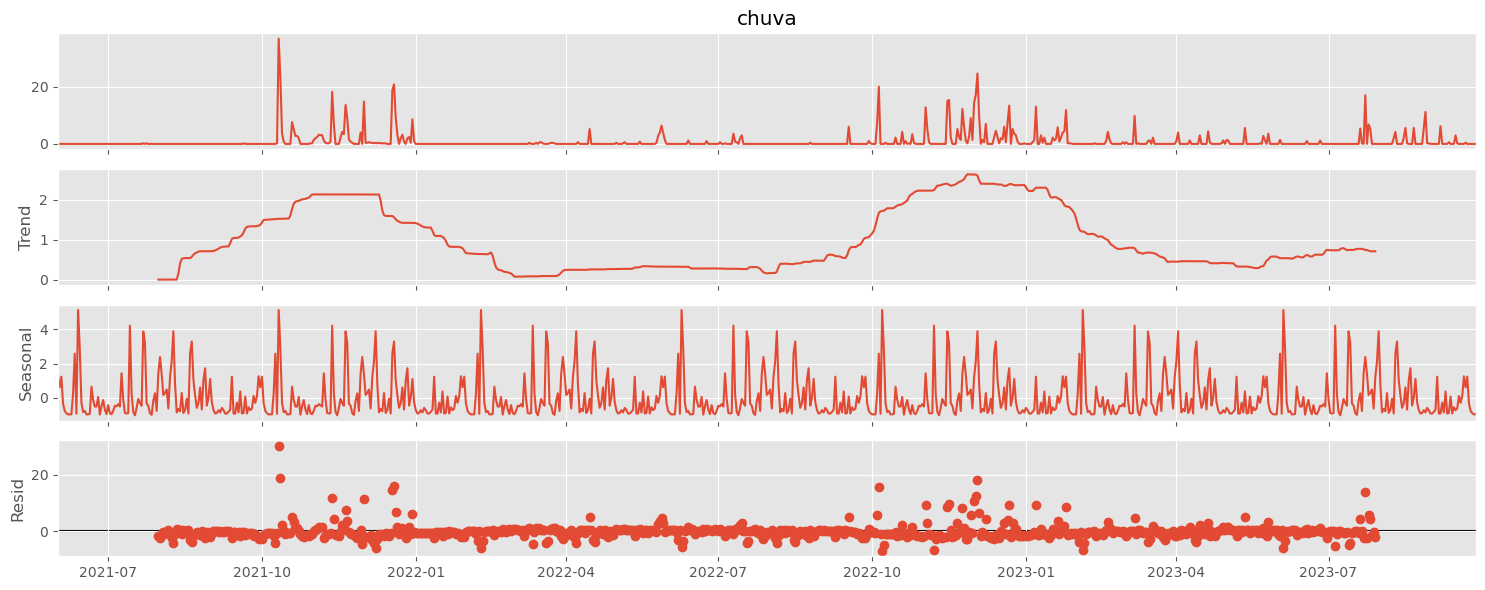

In [20]:
r_chuva = seasonal_decompose(df_media_diaria_2021.chuva, period=120, model="add")
r_chuva.plot();

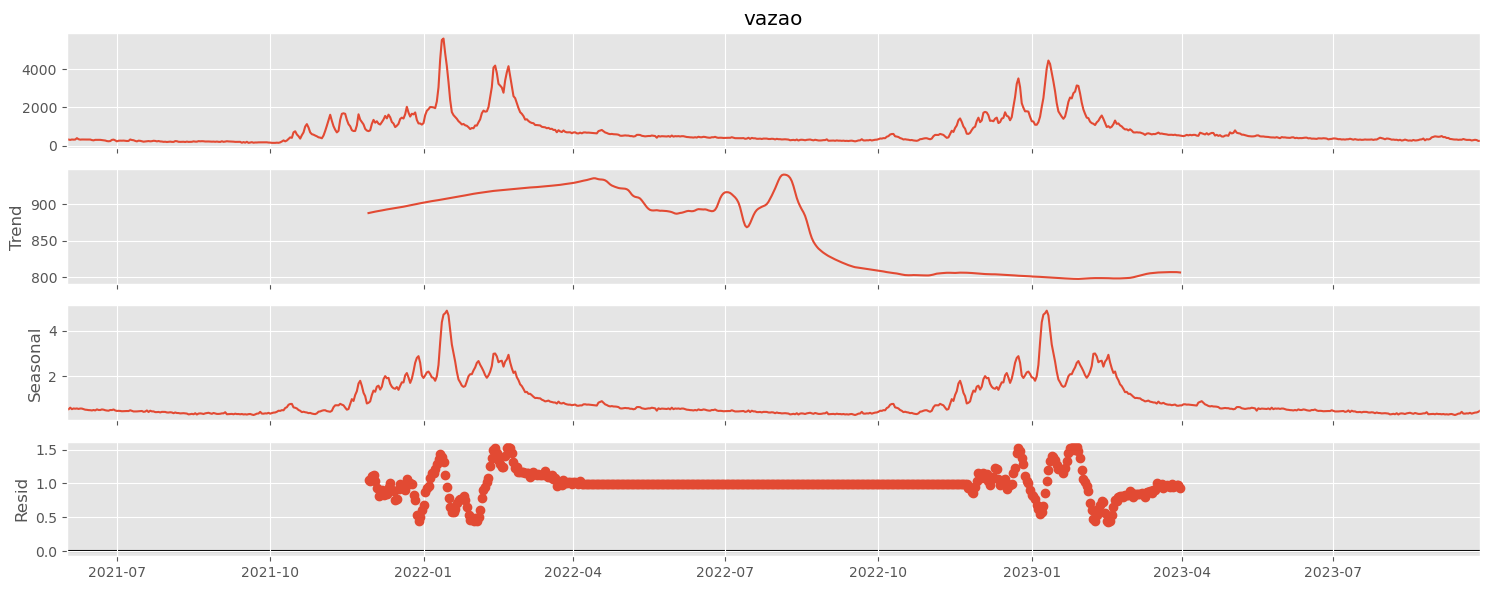

In [21]:
r_vazao = seasonal_decompose(df_media_diaria_2021.vazao, period=360, model="mult")
r_vazao.plot();

### Teste de Estacionariedade

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
# result = adfuller(df_media_diaria_2021.vazao.diff(1).dropna())
result = adfuller(df_media_diaria_2021.vazao)
print(f'Estatística ADF: {result[0]}')
print(f'p-value: {result[1]}')
print('Valores Críticos:')
for key, value in result[4].items():
   print(f'\t{key}: {value}')

Estatística ADF: -2.7804924205635753
p-value: 0.061114768796028514
Valores Críticos:
	1%: -3.438243639935131
	5%: -2.865024299696786
	10%: -2.568625331245176


A série de vazões original é uma série não-estacionária. Apresenta tendência ou sazonalidade, ou ambos.

In [24]:
result = adfuller(df_media_diaria_2021.chuva)
print(f'Estatística ADF: {result[0]}')
print(f'p-value: {result[1]}')
print('Valores Críticos:')
for key, value in result[4].items():
   print(f'\t{key}: {value}')

Estatística ADF: -4.252826044887226
p-value: 0.0005356131650404995
Valores Críticos:
	1%: -3.4382531800005944
	5%: -2.8650285052126057
	10%: -2.5686275714907825


Já a série de chuvas é estacionária.

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'ACF "vazao"')

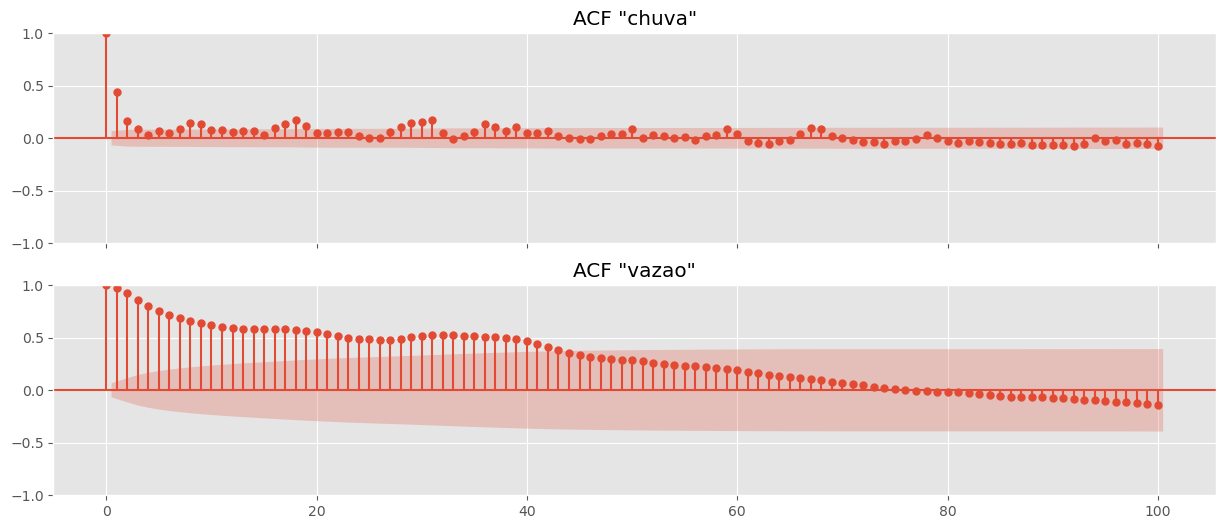

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_acf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('ACF "chuva"')
plot_acf(df_media_diaria_2021.vazao, ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('ACF "vazao"')

Text(0.5, 1.0, 'PACF "vazao"')

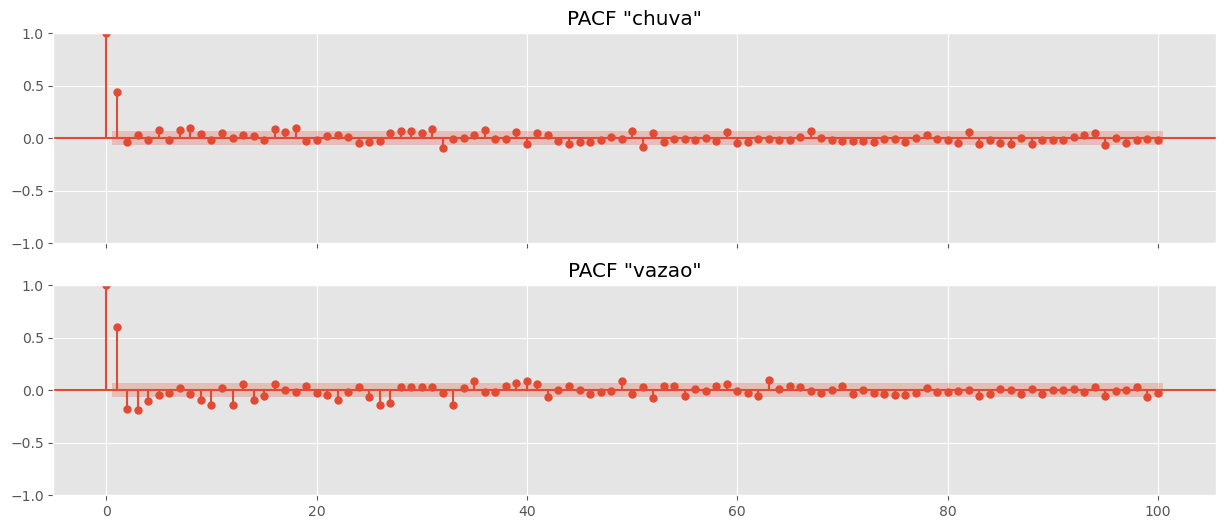

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_pacf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('PACF "chuva"')
plot_pacf(df_media_diaria_2021.vazao.diff(1).dropna(), ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('PACF "vazao"')

Text(0.5, 0, 'Meses')

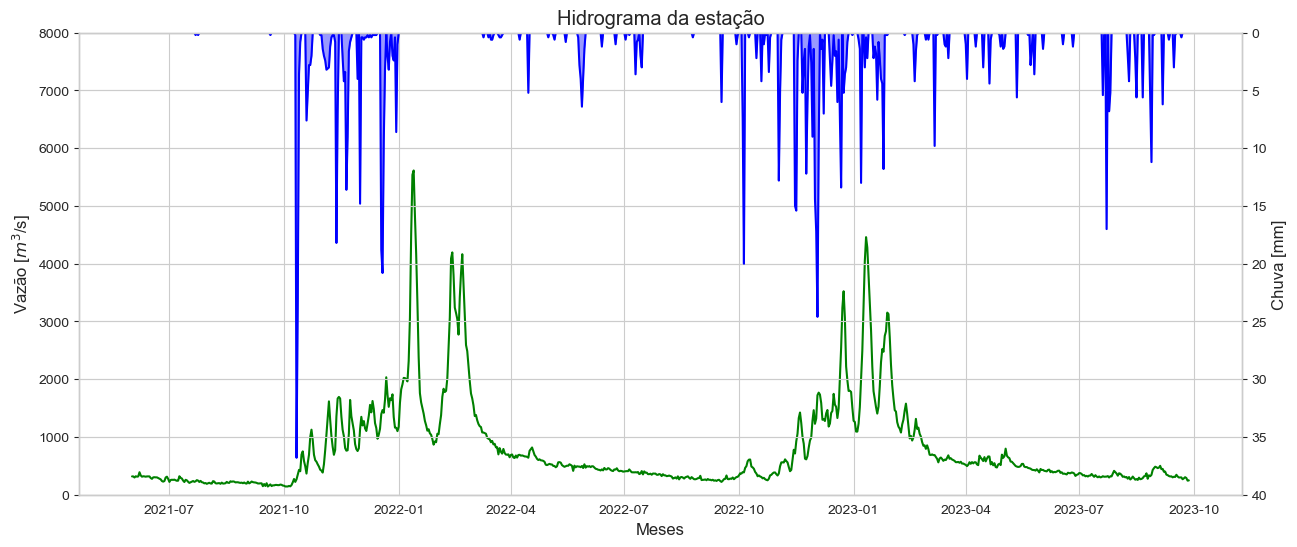

In [28]:
# Hidrograma da estação
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(x=df_media_diaria_2021.index, y="chuva", data=df_media_diaria_2021, color="blue", ax=ax2)
ax2.fill_between(df_media_diaria_2021.index, 0, df_media_diaria_2021["chuva"], color='blue', alpha = 0.4)
ax2.set(ylim=(0, 40))
ax2.set_ylabel("Chuva [mm]")
ax2.invert_yaxis()

sns.lineplot(x=df_media_diaria_2021.index, y="vazao", data=df_media_diaria_2021, color="green", ax=ax1)
ax1.set(ylim=(0, 8000))
ax1.set_title('Hidrograma da estação')
ax1.set_ylabel("Vazão [$m^3$/s]")
ax1.set_xlabel("Meses")

In [29]:
# Precisa equalizar as unidades de medida. Converter m^3 para mm
# Fator de conversão de m^3 para mm^3 -> [mm^3 = m^3 x 1e+9] (1 bilhão)
df_media_diaria_2021.vazao = df_media_diaria_2021.vazao * 1e+9
df_media_diaria_2021

,chuva,vazao
data_hora,,
2021-06-01,0.0,3.170750e+11
2021-06-02,0.0,3.170750e+11
2021-06-03,0.0,2.982300e+11
2021-06-04,0.0,3.194600e+11
2021-06-05,0.0,3.122900e+11
...,...,...
2023-09-23,0.0,2.834826e+11
2023-09-24,0.0,3.033198e+11
2023-09-25,0.0,2.892950e+11


In [30]:
# Vou tabular a série temporal pegando 3 lags pra isso.
# Desta forma, considero que os "t-3" dias anteriores medidos influeciam a medição no tempo "t" e também a chuva prevista para o dia "t".
lags = 3 # quantidade de dias observados passado
targets = 1 # prever apenas vazão
tab_data = sliding_window(df_media_diaria_2021.values, n_lags=lags, n_targets=targets)

# Alterando os nomes das colunas para ficar mais legível.
tab_data.columns=['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'vazao']
# tab_data

In [31]:
# Separo em dois DataFrames. DataFrame de input (X) e DataFrame de output (y)
X = tab_data[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7']]
y = tab_data[['vazao']]

# Resetando os índices e removendo a coluna de índices antiga
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [32]:
# Dividindo os dados entre "treino" e "validação".
X_training, X_validation = split_train_test(X, 0.8)
y_training, y_validation = split_train_test(y, 0.8)

# X_training.shape, X_validation.shape, y_training.shape, y_validation.shape

Um passo importante a se fazer com valores muito grandes é fazer a normalização.
Como a vazão foi convertida de $m^3$ para $mm^3$, isso PRECISA ser feito sob risco da rede se perder.

In [33]:
# Normalizando os valores pois tem valores EXTREMAMENTE distantes.
scaler = MinMaxScaler(feature_range=(0, 1))

X_training_scaled = scaler.fit_transform(X_training) # Apenas os dados de treinamento passam por fit
X_validation_scaled = scaler.transform(X_validation)

y_training_scaled = scaler.fit_transform(y_training) # Apenas os dados de treinamento passam por fit
y_validation_scaled = scaler.transform(y_validation)

# inverse transform and print
# inversed = scaler.inverse_transform(normalized)
# print(inversed)

# X_training_scaled.shape, X_validation_scaled.shape, y_training_scaled.shape, y_validation_scaled.shape

In [34]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(tab_data)
# analyze_report.show_html('analyze.html', open_browser=False)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Ter separado em intervalo de 3 lags parece uma boa.
As associações percebidas pelo SweetViz mostram que uma chuva num dia 't' influencia menos as chuvas 't+2' e 't+3' dias depois.

# LSTM

Usando a implementação da biblioteca **KERAS**

In [35]:
# Variável para armazenar todos os cálculos de desempenho dos modelos empregados
# desempenho = {}

## Preparando os dados

In [36]:
# X de treino
X_lstm = X_training_scaled.reshape(X_training_scaled.shape[0], X_training_scaled.shape[1], 1)
# X_lstm.shape

In [37]:
# y de treino
y_lstm = y_training_scaled.reshape(y_training_scaled.shape[0], y_training_scaled.shape[1], 1)
# y_lstm.shape

In [38]:
# X para pevisão
X_pred_lstm = X_validation_scaled.reshape(X_validation_scaled.shape[0],  X_validation_scaled.shape[1], 1)
# X_pred_lstm.shape

## Vanilla LSTM

In [39]:
vanilla_lstm = Sequential()
vanilla_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
vanilla_lstm.add(Dense(1))
vanilla_lstm.compile(optimizer='adam', loss='mse')

In [40]:
# vanilla_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [41]:
# vazao_pred = vanilla_lstm.predict(X_pred_lstm, verbose=0)

# vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
# vazao_pred_df['observed'] = y_validation_scaled

In [42]:
# plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
#             labels=["observado", "previsão"],
#             x_label='',
#             y_label='Vazão ($m^3/s$)',
#             title='Vanilla LSTM')

# desempenho['VanillaLSTM'] = {'MAPE': mean_absolute_percentage_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                              'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                              'MSE' : mean_squared_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

## Bidirectional LSTM

A característica deste modelo é que ele guarda e passa informações para a célula adiante e retorna para células anteriores informações que foram ajustadas à frente, na rede. Isso potencializa o aprendizado do modelo.

In [43]:
bidir_lstm = Sequential()
bidir_lstm.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1))))
bidir_lstm.add(Dense(1))
bidir_lstm.compile(optimizer='adam', loss='mse')

In [44]:
# bidir_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [45]:
# vazao_pred = bidir_lstm.predict(X_pred_lstm, verbose=0)

# vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
# vazao_pred_df['observed'] = y_validation_scaled

In [46]:
# plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
#             labels=["observado", "previsão"],
#             x_label='',
#             y_label='Vazão ($m^3/s$)',
#             title='Bidirectional LSTM')

# desempenho['BidirectionalLSTM'] = {'MAPE': mean_absolute_percentage_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                                    'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                                    'MSE' : mean_squared_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

## Stacked LSTM

A ideia aqui é criar um modelo com mais de uma camada oculta, visando o aprimoramento dos resultados.

In [47]:
stkd_lstm = Sequential()
stkd_lstm.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
stkd_lstm.add(LSTM(128, activation='relu'))
stkd_lstm.add(Dense(1))
stkd_lstm.compile(optimizer='adam', loss='mse')

In [48]:
# stkd_lstm.fit(X_lstm, y_lstm, epochs=250, verbose=0)

In [49]:
# vazao_pred = stkd_lstm.predict(X_pred_lstm, verbose=0)

# vazao_pred_df = pd.DataFrame(data=vazao_pred, columns=['pred'])
# vazao_pred_df['observed'] = y_validation_scaled

In [50]:
# plot_series(vazao_pred_df['observed'], vazao_pred_df['pred'],
#             labels=["observado", "previsão"],
#             x_label='',
#             y_label='Vazão ($m^3/s$)',
#             title='Stacked LSTM')

# desempenho['StackedLSTM'] = {'MAPE': mean_absolute_percentage_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                              'R2': r2_score(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values),
#                              'MSE' : mean_squared_error(vazao_pred_df['observed'].values, vazao_pred_df['pred'].values)}

## Stacked Bidirectional LSTM

In [51]:
stkd_bi_lstm = Sequential()
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1))))
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu')))
stkd_bi_lstm.add(Dense(1))
stkd_bi_lstm.compile(optimizer='adam', loss='mse')

In [52]:
# Faz o print da qualidade dos resultados de cada método empregado

# for _m1 in desempenho.items():
#   print(_m1[0] + "\n\t" + "MAPE:\t" + str(_m1[1]['MAPE'])
#                + "\n\t" + "R2:\t"   + str(_m1[1]['R2'])
#                + "\n\t" + "MSE:\t"  + str(_m1[1]['MSE']))

# desempenho_df = pd.DataFrame(data=desempenho)
# desempenho_df

In [53]:
# Executando os 4 modelos em lote

# Variável que criará a chave
k = ''

# Preferi separar o resultado por cada tipo de rede para me facilitar depois visualizar os resultados
pred_van, pred_bidir, pred_stkd, pred_stkd_bi = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Um DataFrame para armazenar o desempenho de cada run de cada modelo
desempenho = {}
tot_runs = 5

for i in range(0, tot_runs):
  k = 'van_run_' + str(i+1)
  vanilla_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
  pred_van[k] = pd.DataFrame(data=vanilla_lstm.predict(X_pred_lstm, verbose=0))
  desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_van[k].values),
                   'R2': r2_score(y_validation_scaled, pred_van[k].values),
                   'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_van[k].values)),
                   'MASE' : mase(y_validation_scaled, pred_van[k], y_train=y_training_scaled)}

  k = 'bidir_run_' + str(i+1)
  bidir_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
  pred_bidir[k] = pd.DataFrame(data=bidir_lstm.predict(X_pred_lstm, verbose=0))
  desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_bidir[k]),
                   'R2': r2_score(y_validation_scaled, pred_bidir[k]),
                   'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_bidir[k])),
                   'MASE' : mase(y_validation_scaled, pred_bidir[k], y_train=y_training_scaled)}

  k = 'stkd_run_' + str(i+1)
  stkd_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
  pred_stkd[k] = pd.DataFrame(data=stkd_lstm.predict(X_pred_lstm, verbose=0))
  desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_stkd[k]),
                   'R2': r2_score(y_validation_scaled, pred_stkd[k]),
                   'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_stkd[k])),
                   'MASE' : mase(y_validation_scaled, pred_stkd[k], y_train=y_training_scaled)}
  
  k = 'stkd_bi_run_' + str(i+1)
  stkd_bi_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
  pred_stkd_bi[k] = pd.DataFrame(data=stkd_bi_lstm.predict(X_pred_lstm, verbose=0))
  desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_stkd_bi[k]),
                   'R2': r2_score(y_validation_scaled, pred_stkd_bi[k]),
                   'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_stkd_bi[k])),
                   'MASE' : mase(y_validation_scaled, pred_stkd_bi[k], y_train=y_training_scaled)}

In [54]:
# Filtrar as colunas do dataframe de desempenho pelo modelo rodado

# Analisando as execuções do modelo Vanilla LSTM
cols = [str('van_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

,SMAPE,R2,RMSE,MASE
count,5.000000,5.000000,5.000000,5.000000
mean,0.144430,0.772389,0.009629,0.369307
std,0.035871,0.072289,0.001478,0.063080
min,0.114989,0.655077,0.008106,0.308006
25%,0.127712,0.756172,0.008948,0.343072
50%,0.128238,0.801920,0.009067,0.353595
75%,0.145649,0.807101,0.010060,0.366646
max,0.205560,0.841674,0.011965,0.475214


<AxesSubplot:title={'center':'Vanilla LSTM'}>

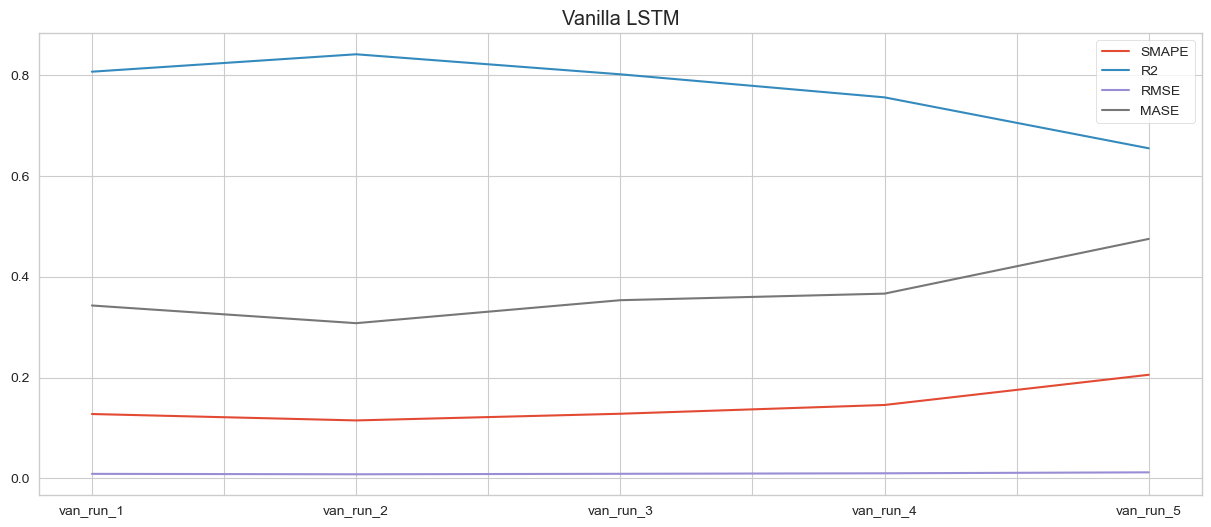

In [55]:
desempenho_df[cols].T.plot(title='Vanilla LSTM')

In [56]:
# Analisando as execuções do modelo Bidirectional LSTM
cols = [str('bidir_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

,SMAPE,R2,RMSE,MASE
count,5.000000,5.000000,5.000000,5.000000
mean,0.144632,0.787778,0.009365,0.366013
std,0.012993,0.030616,0.000686,0.025380
min,0.128910,0.756822,0.008435,0.333388
25%,0.133533,0.762928,0.008895,0.349023
50%,0.147688,0.781192,0.009530,0.368115
75%,0.153952,0.809385,0.009919,0.383054
max,0.159079,0.828561,0.010046,0.396488


<AxesSubplot:title={'center':'Bidirectional LSTM'}>

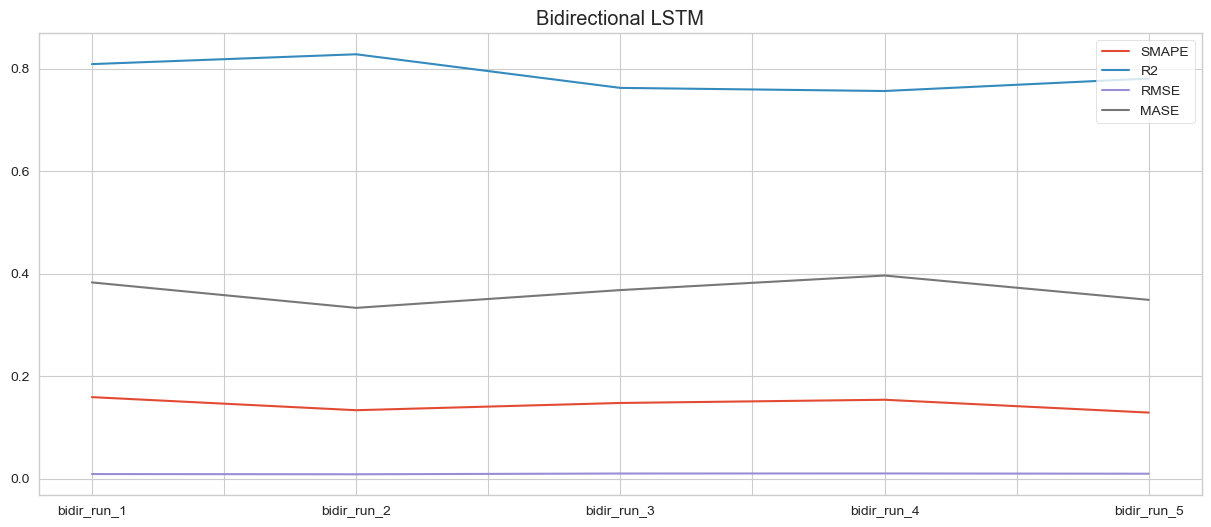

In [57]:
desempenho_df[cols].T.plot(title='Bidirectional LSTM')

In [58]:
# Analisando as execuções do modelo Stacked LSTM
cols = [str('stkd_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

,SMAPE,R2,RMSE,MASE
count,5.000000,5.000000,5.000000,5.000000
mean,0.155609,0.716598,0.010807,0.394855
std,0.019455,0.055345,0.001016,0.043323
min,0.135607,0.621783,0.009821,0.350159
25%,0.141374,0.727436,0.010523,0.366907
50%,0.148475,0.732994,0.010527,0.380714
75%,0.174778,0.733177,0.010636,0.418712
max,0.177810,0.767598,0.012529,0.457781


<AxesSubplot:title={'center':'Stacked LSTM'}>

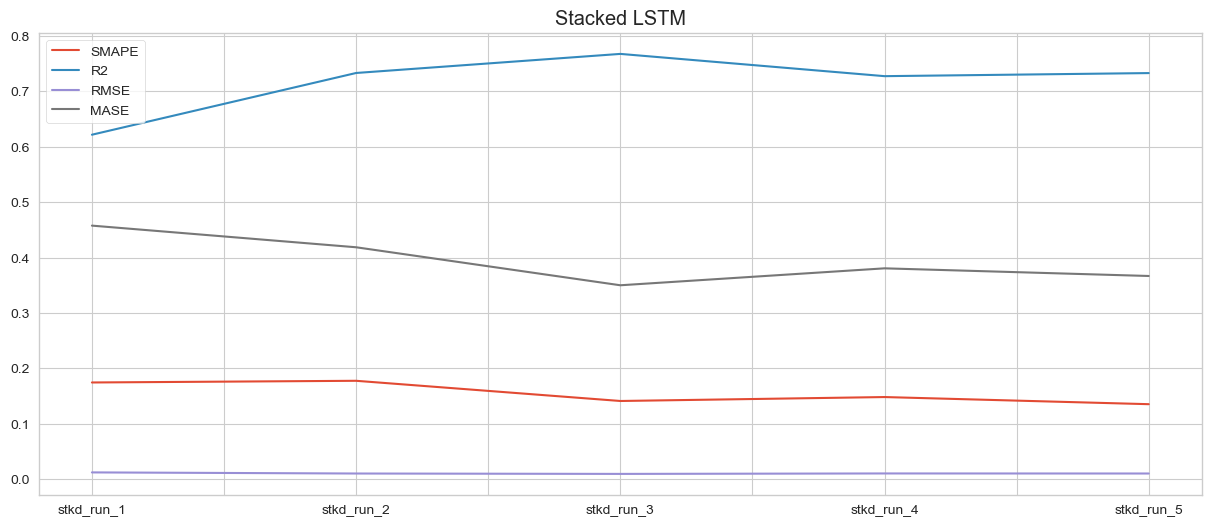

In [59]:
desempenho_df[cols].T.plot(title='Stacked LSTM')

In [60]:
# Analisando as execuções do modelo Stacked LSTM
cols = [str('stkd_bi_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

,SMAPE,R2,RMSE,MASE
count,5.000000,5.000000,5.000000,5.000000
mean,0.156487,0.652303,0.011802,0.438885
std,0.044995,0.149349,0.002505,0.134247
min,0.125037,0.443332,0.009704,0.348909
25%,0.131726,0.545110,0.009900,0.361382
50%,0.134836,0.736126,0.010465,0.363622
75%,0.156717,0.763840,0.013740,0.453347
max,0.234121,0.773109,0.015200,0.667168


<AxesSubplot:title={'center':'Stacked Bidirectional LSTM'}>

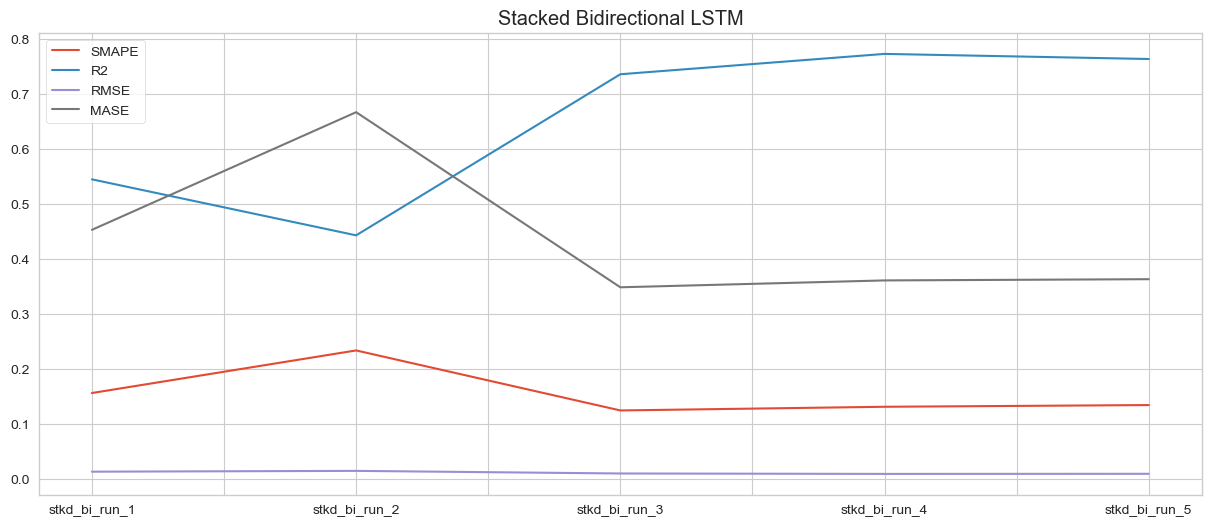

In [61]:
desempenho_df[cols].T.plot(title='Stacked Bidirectional LSTM')

# NeuralForecast

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable.

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [52]:
# Y_df = AirPassengersDF # Defined in neuralforecast.utils
# Y_df

DataFrames must include all `['unique_id', 'ds', 'y']` columns.

**Make sure `y` column does not have missing or non-numeric values.**

In [65]:
# key='1OKeFE_6M553VnYzAQOTnkozp0ma5Rvg2fWR4qwYyC68'
# link='https://docs.google.com/spreadsheet/ccc?key='+key+'&output=csv'
# dataset = pd.read_csv(link, sep=',')
# dataset['data'] = [i.split(' ')[0] for i in dataset['Data']]
# dataset=dataset.groupby('data').agg(np.mean)
# dataset['data'] = pd.to_datetime(dataset.index, format='%Y-%m-%d')
# dataset = dataset.fillna(dataset.mean())
# dataset.drop(['Nível', ], axis=1, inplace=True)

df = df_media_diaria_2021.copy()

# training_size = round(len(df) * 0.8) # 80% de treinamento / 20% de validação
fch = 90 # Forecast Horizon // Últimos 90 dias (3 meses)
training_size = len(df) - fch

df['ds'] = pd.to_datetime(df.index.values)
df['unique_id'] = 1.0
df['y'] = df.vazao
df.drop('vazao', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True) # retira a data_hora como índice do DataFrame.

# Precisa normalizar as colunas de 'chuva' e 'y' (vazao)
# mydata[['x1','x2','x3']] = MinMaxScaler().fit_transform(mydata[['x1','x2','x3']])
# df[['chuva','y']] = scaler.fit_transform(df[['chuva','y']])
# df

# df['data_hora'] = df.index
# df.index=df['datetime']
# df['value'] = df['Vazão']

# df['datetime'] = pd.to_datetime(df['datetime'])

# # Plot data
# df.plot('datetime', 'value')
# plt.show()

# Y_df=pd.DataFrame()
# Y_df['ds']=df['datetime']
# Y_df['y']=df['Vazão']
# Y_df['unique_id'] = 1.0
# Y_df['y'].plot()
# Y_df=Y_df[['unique_id', 'ds', 'y']]
# Y_df

# df

# df.plot('ds', ['chuva', 'y'], xlabel='Meses', ylabel='y', label=['chuva', 'vazão'], color=['b', 'g'])
# plt.show()

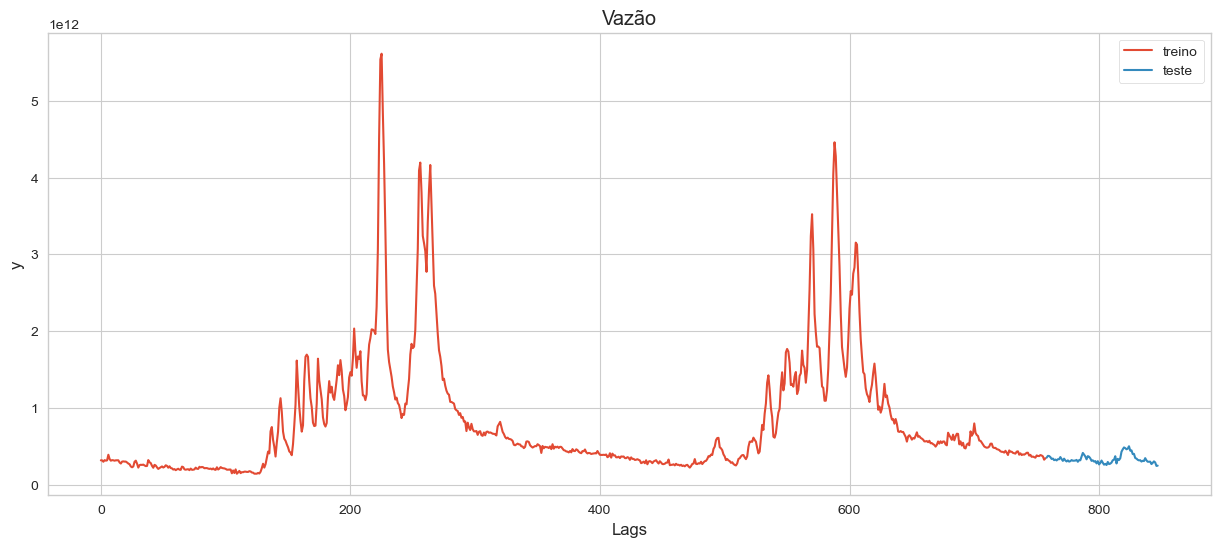

In [54]:
df_train  = df[:training_size]
df_test = df[training_size:]

# df_train, df_test

# horizon = 720
# n=len(Y_df)-horizon
# Y_df_test = Y_df[-horizon::]
# Y_df_train  = Y_df[:n]

# n, horizon, len(Y_df_train), len(Y_df_test)

# Y_df_train['y'].plot()
# Y_df_test['y'].plot()

df_train['y'].plot(label='treino')
df_test['y'].plot(label='teste')
plt.title('Vazão')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

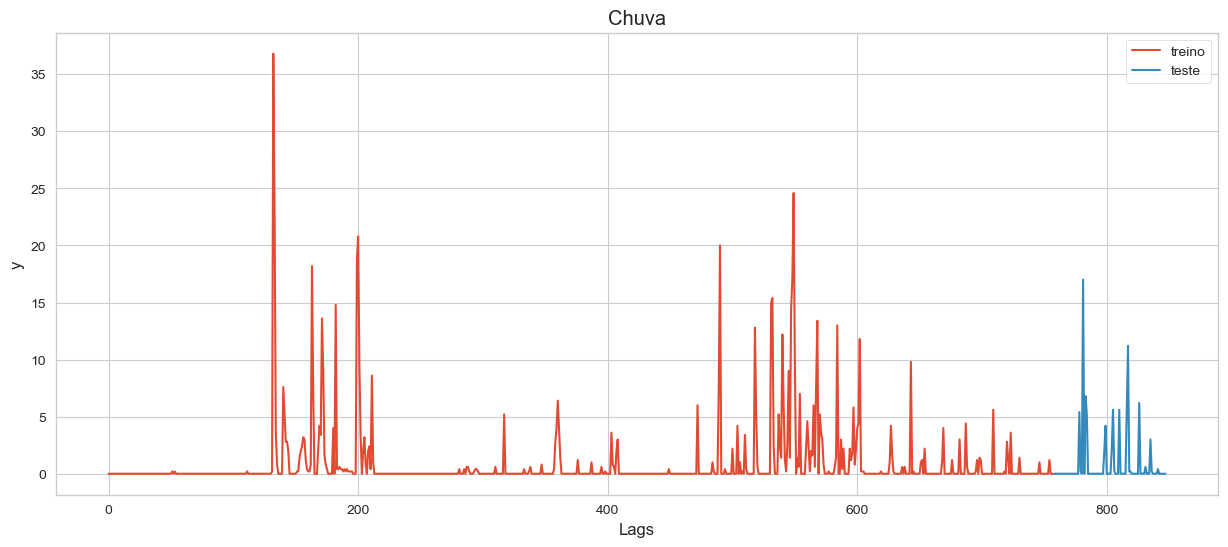

In [55]:
df_train['chuva'].plot(label='treino')
df_test['chuva'].plot(label='teste')
plt.title('Chuva')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

In [56]:
# df_test

## 3. Model Training

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `LSTM` we changed the default hidden size for both encoder and decoders.

In [81]:
# Try different hyperparmeters to improve accuracy.
models = [
          nfLSTM(h=fch,                      # Forecast horizon // 90 dias
               max_steps=300,                # Number of steps to train
               scaler_type='robust',         # Type of scaler to normalize data
               futr_exog_list=['chuva'],     # Variáveis adicionais que comporão o modelo
               #input_size=4*fch,             # Olha para os (2 * fch) dias anteriores à previsão com mais atenção
               encoder_hidden_size=128,      # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64)       # Defines the number of hidden units of each layer of the MLP decoder

      #     NHITS(h=len(df_test),              # Forecast horizon
      #           input_size=2 * len(df_test), # Length of input sequence
      #           max_steps=300,               # Number of steps to train
      #           n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output

          #AutoRNN(h=horizon,
          #        config=dict(max_steps=2, val_check_steps=1, input_size=-1, encoder_hidden_size=8),
          #        num_samples=1, cpus=1),
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_train)

Seed set to 1


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s, v_num=33, train_loss_step=0.237, train_loss_epoch=0.237]


In [82]:
# Precisa extrair do conjunto de teste os dados das variáveis em 'futr_exog_list' e usar apenas elas pra fazer predict
chuvas_futuras = df_test[['unique_id', 'ds', 'chuva']]
chuvas_futuras

,unique_id,ds,chuva
758,1.0,2023-06-30,0.0
759,1.0,2023-07-01,0.0
760,1.0,2023-07-02,0.0
761,1.0,2023-07-03,0.0
762,1.0,2023-07-04,0.0
...,...,...,...
843,1.0,2023-09-23,0.0
844,1.0,2023-09-24,0.0
845,1.0,2023-09-25,0.0
846,1.0,2023-09-26,0.0


:::{.callout-tip}
The performance of Deep Learning models can be very sensitive to the choice of hyperparameters. Tuning the correct hyperparameters is an important step to obtain the best forecasts. The `Auto` version of these models, `AutoLSTM` and `AutoNHITS`, already perform hyperparameter selection automatically.
:::

### Predict using the fitted models

Using the `NeuralForecast.predict` method you can obtain the `h` forecasts after the training data `Y_df`.

In [83]:
df_pred = nf.predict(futr_df=chuvas_futuras)
df_pred

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s]


,ds,LSTM
unique_id,,
1.0,2023-06-30,3.408525e+11
1.0,2023-07-01,3.306534e+11
1.0,2023-07-02,3.819166e+11
1.0,2023-07-03,4.134125e+11
1.0,2023-07-04,3.518849e+11
...,...,...
1.0,2023-09-23,6.746256e+11
1.0,2023-09-24,6.613577e+11
1.0,2023-09-25,5.190688e+11


The `NeuralForecast.predict` method returns a DataFrame with the forecasts for each `unique_id`, `ds`, and model.

In [84]:
# Só precisa executar isso uma vez
df_pred = df_pred.reset_index()

In [86]:
df_pred['y'] = df_test['y'].values
df_pred

,unique_id,ds,LSTM,y
0,1.0,2023-06-30,3.408525e+11,3.516870e+11
1,1.0,2023-07-01,3.306534e+11,3.748735e+11
2,1.0,2023-07-02,3.819166e+11,3.730736e+11
3,1.0,2023-07-03,4.134125e+11,3.586511e+11
4,1.0,2023-07-04,3.518849e+11,3.347016e+11
...,...,...,...,...
85,1.0,2023-09-23,6.746256e+11,2.834826e+11
86,1.0,2023-09-24,6.613577e+11,3.033198e+11
87,1.0,2023-09-25,5.190688e+11,2.892950e+11
88,1.0,2023-09-26,5.604187e+11,2.440501e+11


0.35610774846591126

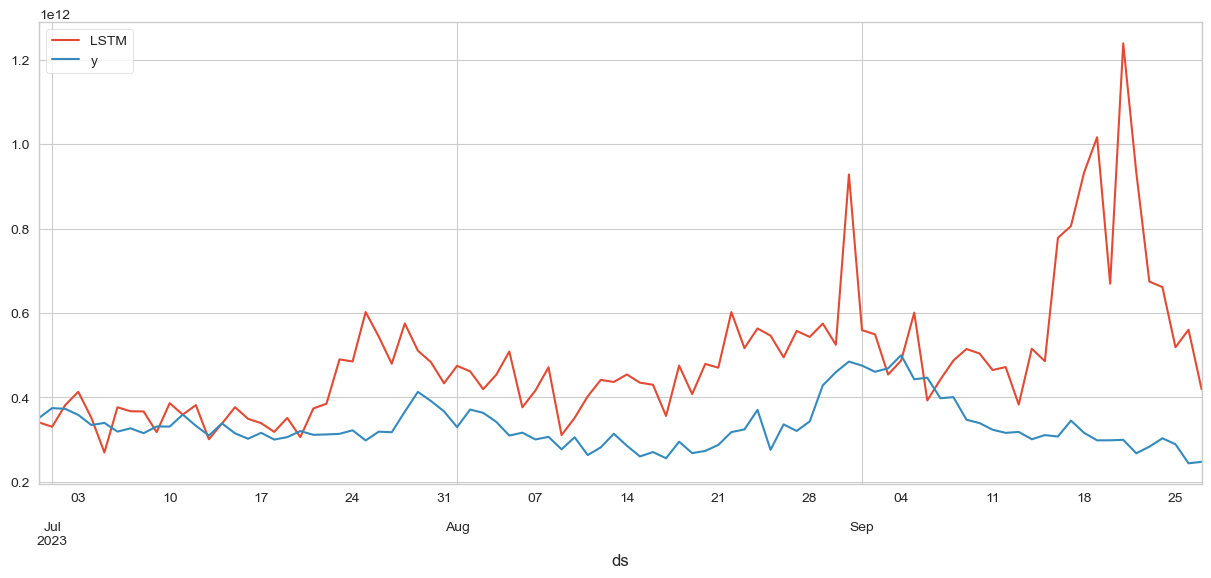

In [87]:
df_pred.plot('ds', ['LSTM', 'y'])
smape(df_pred['y'], df_pred['LSTM'])#, r2_score(df_pred['y'], df_pred['NHITS'])

In [94]:
# Testando o AutoLSTM para detecção dos melhores parâmetros
from neuralforecast.auto import AutoLSTM
from neuralforecast.losses.pytorch import MAPE

models_auto = [AutoLSTM(h=fch,
                        num_samples=3)]

m_auto = NeuralForecast(models=models_auto, freq='D')

In [95]:
m_auto.fit(df=df_train, val_size=30)

(_train_tune pid=18412) Seed set to 16
(_train_tune pid=18412) Exception in thread Thread-4:
(_train_tune pid=18412) Traceback (most recent call last):
(_train_tune pid=18412)   File "c:\Users\welson\anaconda3\envs\neuralfc_py310\lib\threading.py", line 1016, in _bootstrap_inner
(_train_tune pid=18412)     self.run()
(_train_tune pid=18412)   File "c:\Users\welson\anaconda3\envs\neuralfc_py310\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 233, in run
(_train_tune pid=18412)     self._record_writer.write(data)
(_train_tune pid=18412)   File "c:\Users\welson\anaconda3\envs\neuralfc_py310\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
(_train_tune pid=18412)     self._writer.write(header + header_crc + data + footer_crc)
(_train_tune pid=18412)   File "c:\Users\welson\anaconda3\envs\neuralfc_py310\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 99, in write
(_train_tune pid=18412)     self._prewrite_check()
(_train

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [ ]:
m_auto.predict()

Exception: You must fit the model before predicting.

## 4. Plot Predictions

Finally, we plot the forecasts of both models againts the real values.

<Axes: xlabel='ds'>

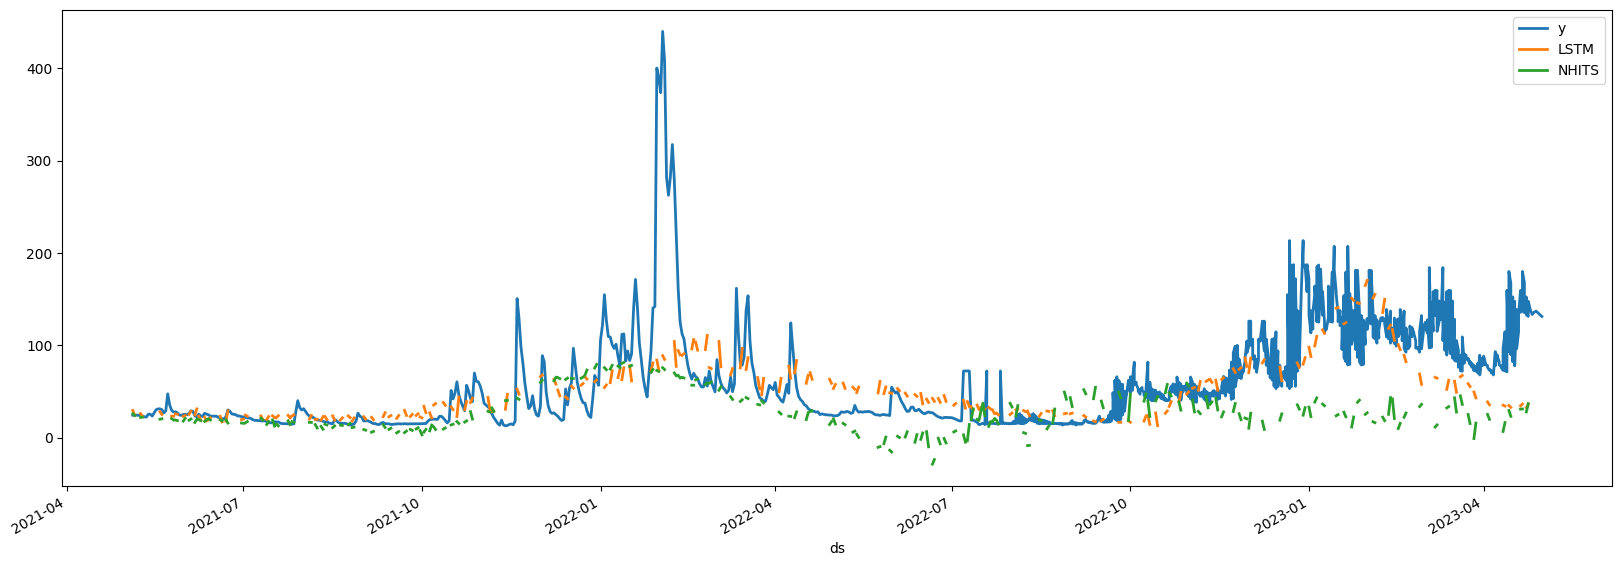

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df_test, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y',
         'LSTM',
         'NHITS',
         #'AutoRNN',
         ]].plot(ax=ax, linewidth=2)

#ax.set_title('AirPassengers Forecast', fontsize=22)
#ax.set_ylabel('Monthly Passengers', fontsize=20)
#ax.set_xlabel('Timestamp [t]', fontsize=20)
#ax.legend(prop={'size': 15})
#ax.grid()

:::{.callout-tip}
For this guide we are using a simple `LSTM` model. More recent models, such as `RNN`, `GRU`, and `DilatedRNN` achieve better accuracy than `LSTM` in most settings. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).
:::

<Axes: xlabel='datetime'>

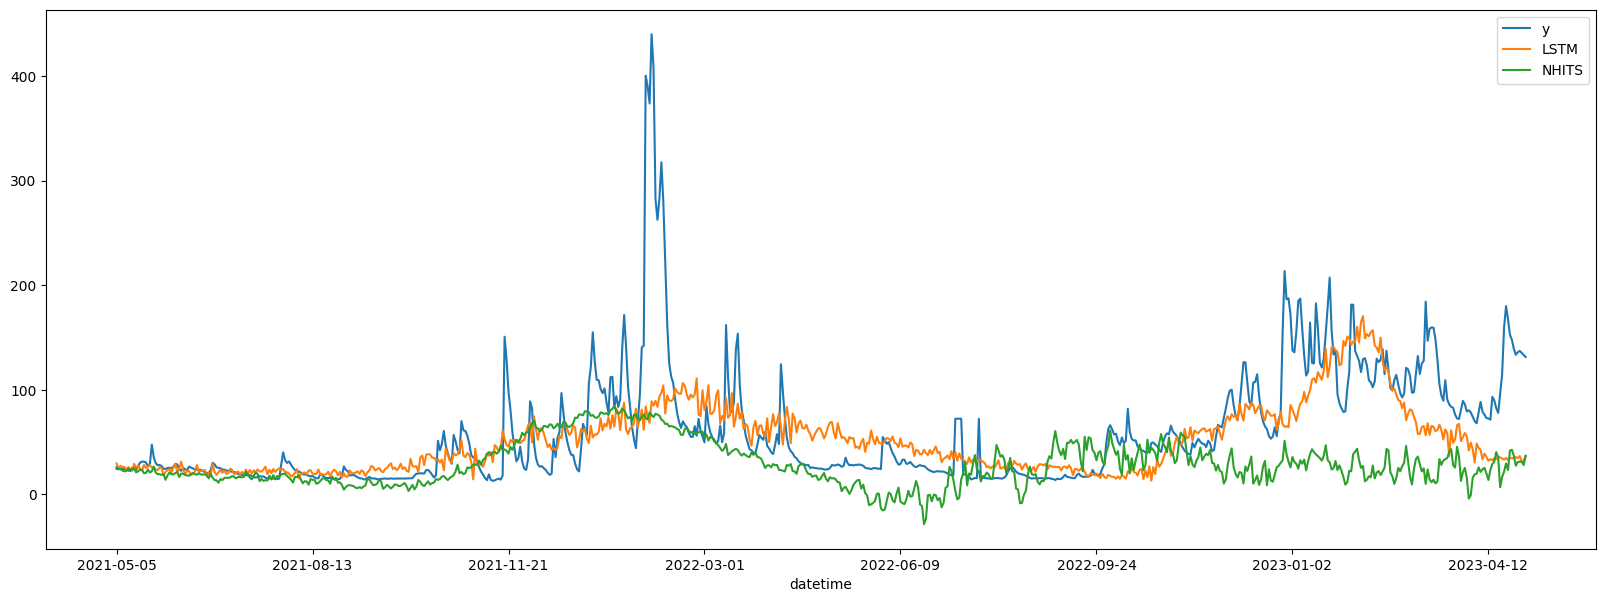

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

Y_hat_df.index=Y_df_test.index
Y_hat_df[['y',
         'LSTM',
         'NHITS',
         #'AutoRNN',
         ]].plot(ax=ax)

## References
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)<br>
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)